In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
fyps = pd.read_csv('fyps.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269840']
this_star

,CommonName,ContRatio,Dec,Dec_y,MKType,MatchID,RA,RA_y,SimbadOType,SimbadSpT,...,w3mag,w4mag,alpha,e_alpha,tau,e_tau,gamma,e_gamma,alpha_w,e_alpha_w
3,HD 269840,NaN,-68.928129,NaN,G0,277108449,84.042007,NaN,YellowSG*,F3Ia,...,8.577,8.336,0.00874,0.000274,0.125686,0.004451,2.300546,0.063904,0.002034,0.000001


In [3]:
#prewhitening
tic = this_star['TIC ID'].iloc[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten(time, flux, err)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
freq, power = LombScargle(time, flux, dy=err).autopower(normalization='psd')
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)

10
Found 16 frequencies
16 unique frequencies


In [4]:
for f,s in zip(good_fs,good_snrs):
    print(f[0],s)

2.269719753511981 60.42890877337002
3.404453858735834 45.106108063563866
1.1346895364807918 41.31479555040901
4.539117402715377 38.36036231323797
2.8365716868281146 33.15907152155169
0.7166861028249487 18.035250895144475
3.972016421352115 32.53607891644041
1.3850532877271313 21.68580628727742
5.106253655342285 21.8935225401515
5.674575007717792 10.984289861087001
1.7024302956318056 10.603609325271064
1.5804069569674417 20.461538677069175
2.5655488486055376 10.286978793479925
2.0816680640813163 18.71936286597248
0.5441014942524344 33.28815076276719
1.3242422357403207 5.896840347835546


In [5]:
print(harmonic_search(good_fs))

[[1.7024303 ]
 [3.40445386]
 [2.        ]]


In [6]:
ls_dict = {0:'--',1:'-.',2:':'}

In [7]:
tall = good_fs[0,0]
undetected = tall/4

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


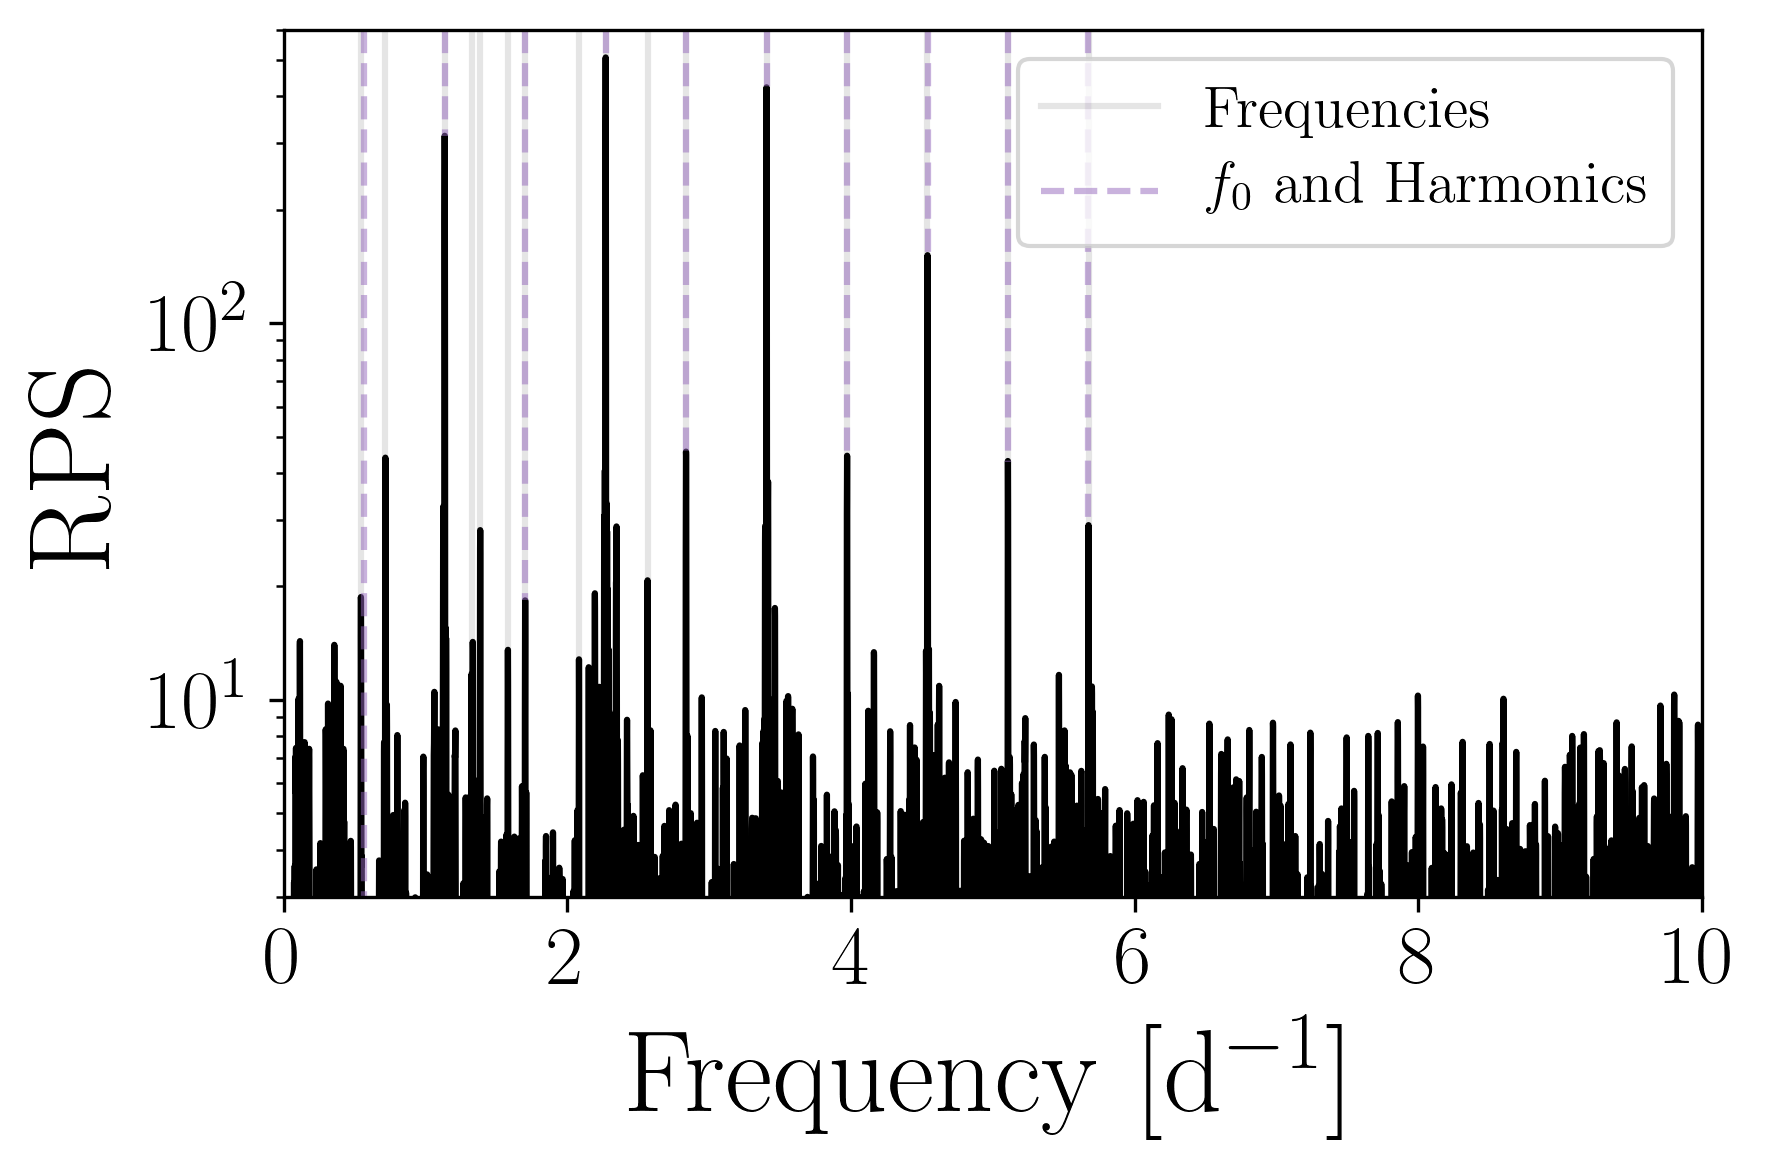

In [10]:
fig = plt.figure(dpi=300)
plt.semilogy(freq, resid,c='k')

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='RPS', xlim=(0,10),ylim=(3,600))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],resid[np.argmin(np.abs(freq-good_fs[0,0]))]],alpha=0.1,c='k',label='Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c='k',alpha=0.1)

plt.plot([undetected,undetected],[ylim[1],resid[np.argmin(np.abs(freq-undetected))]],c=f'C4',ls='--',alpha=0.5,label = r'$f_0$ and Harmonics')
for i in [2,3,4,5,6,7,8,9,10]:
    plt.plot([undetected*i,undetected*i],[ylim[1],resid[np.argmin(np.abs(freq-undetected*i))]],ls='--',alpha=0.5,c=f'C4')

ax.set_ylim(ylim)
leg = ax.legend(fontsize=14)
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/hd269840_frequencies.pdf')

In [13]:
#WWZ wavelet fun
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125
y = flux.values
t = time.values
omega_start = -1 #log2(1/32)
omega_end = 5.5 #log2(16) 
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


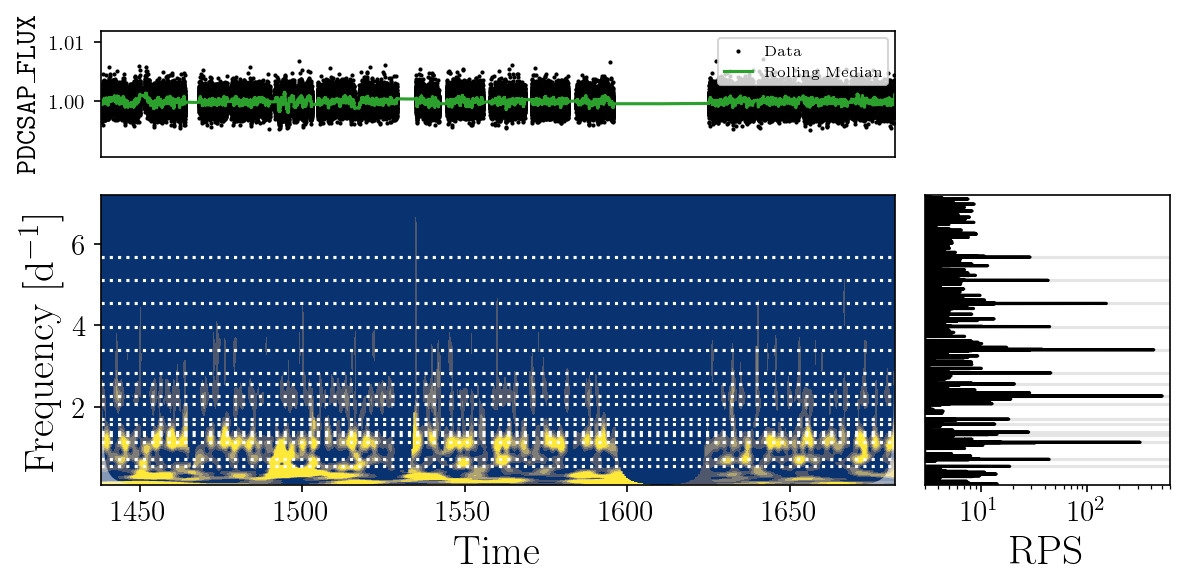

In [14]:
fig = plt.figure(constrained_layout=True,figsize=(8,4),dpi=150)

gs = GridSpec(3, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:,:3])
zsumax = fig.add_subplot(gs[1:,3])

lcax.scatter(time,flux,s=1,c='k',label=r'Data',rasterized=True)
lcax.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C2',label=r'Rolling Median',rasterized=True)
lcax.set(ylabel=r'$\mathrm{\tt PDCSAP\\\_FLUX}$',xlim=(np.min(time),np.max(time)),xticks=[])
h, l = lcax.get_legend_handles_labels()
lcax.legend(h[::-1],l[::-1],loc='upper right',fontsize='x-small')

wwzax.contourf(taus,omegas/2.0/np.pi,wwz,levels=100,cmap='cividis',vmax=50)
wwzax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Frequency [d$^{-1}$]',xlabel='Time',
          ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))



zsumax.semilogx(resid,freq,c='k',rasterized=True)
zsumax.set(yticks=[],xlabel=r'RPS',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)),
           xlim=(3,600))
zs_lim = zsumax.get_xlim()
for f in good_fs[:,0]:
    wwzax.axhline(y=f,c='white',ls=':')
    zsumax.plot([zs_lim[1],resid[np.argmin(np.abs(freq-f))]],[f,f],c='k',alpha=0.1)
for ax in [lcax,wwzax,zsumax]:
    if ax == lcax:
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
    else:
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
    plt.tight_layout()
plt.savefig('../plots/hd269840_wwz.pdf')

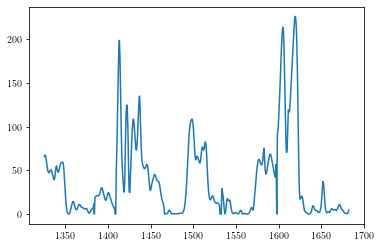

In [31]:
ridge = wwz[np.argmin(np.abs(omegas/2/np.pi - good_fs[0,0])),:]
plt.plot(taus,ridge)
plt.savefig('WOW_time')

0.010362376990261707


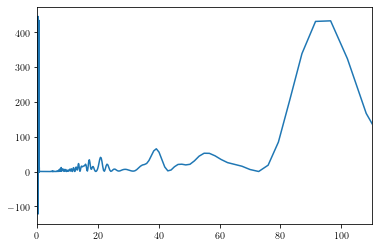

In [39]:
ls_ridge = LombScargle(taus, ridge)
f_ridge, pow_ridge = ls_ridge.autopower(normalization='psd')
pow_ridge /= len(taus)
window = (1.0/f_ridge <= 110) & (1.0/f_ridge >= 40)
plt.plot(1/f_ridge,pow_ridge)
plt.xlim(0,110)
print(f_ridge[window][np.argmax(pow_ridge[window])])
plt.savefig('WOW_power')